# Tarea 1

Aspectos formales en Base a la Norma Técnica de Seguridad y Calidad de Servicio 




## 2.a) Límites admisibles operacionales para el estudio 

### Referente Articulo 5-19 (Shunt)

Tensión nominal Barrras

    -Igual o superior a 500 [kV] =  0,97 y 1,03 por unidad  

    -Igual o superior a 200 [kV] e inferior a 500 [kV] =  0,95 y 1,05 por unidad

    - Inferior a 200 [kV] = 0,93 y 1,07 por unidad

### Referente Articulo 5-23 (Estado de alerta)

    -Igual o superior a 500 [kV] = 0,95 y 1,05 por unidad

    -Igual o superior a 200 [kV] e inferior a 500 [kV] =  0,93 y 1,07 por unidad

    -Inferior a 200 [kV] = 0,90 y 1,10 por unidad

## 2.b) Modelamiento de Parametros concentrados:



Modelo π parametros concentrados

<div>
<img src="modelo.png" width="300"/>
</div>



In [ ]:
# Matriz ABCD Línea larga
import numpy as np

Z1= 0.02+0.115j
Y1= 0+1.5708*10**(-6)*1j
l=500

Z= Z1*l
Y= Y1*l

gamma= np.sqrt(Z1*Y1) 
Zc= np.sqrt(Z1/Y1)

print("gamma=", gamma)
print("Zc=", Zc)

x=gamma*l
Zp= Z * (np.sinh(x))/x
Yp= Y * (np.tanh(x/2))/(x/2)

#A= 1+(Y*Z)/2
#B= Z
#C= Y*(1+((Y*Z)/4))
#D= A

A= 1+(x**2)/2
B= Zc*(x+(x**3)/6)
C= (x+(x**3)/6)/Zc
D=A

print("Zp =", Zp)
print("Yp =", Yp)

print("A =", A)
print("B =", B)
print("C =", C)
print("D =", D)



### -Diferencias con modelo de párametros distribuidos: 
        Los parámetros concentrados confinan los efectos totales de la línea a una región pequeña del espacio. Por otro lado, los parámetros distribuidos se refieren a variables que están distribuidas espacialmente, destacándose la variabilidad de la impedancia serie, característica que no se observa en los parámetros concentrados.

        -La librería escogida trabaja el modelo de parametros concentrados 


### Figura 1(a)
<div>
<img src="Figura a.png" width="300"/>
</div>


## 3.a) Comportamiento de la tensión para una carga que varía en el rango de +-50%

### Código y figura 

      name  vn_kv type  zone  in_service
0  Barra 1  500.0    b  None        True
1  Barra 2  500.0    b  None        True
      name std_type  from_bus  to_bus  length_km  r_ohm_per_km  x_ohm_per_km  \
0  Línea 1  linea_a         0       1      500.0          0.02         0.115   

   c_nf_per_km  g_us_per_km  max_i_ka   df  parallel type  in_service  
0         19.1          0.0       1.0  1.0         2  NaN        True  
Tensión receptor= [1.0490783862373625, 1.0480882621559247, 1.047094687822527, 1.0460976373455344, 1.045097084488373, 1.0440930026631317, 1.0430853649240137, 1.042074143960626, 1.0410593120911094, 1.0400408412550985, 1.0390187030065106, 1.0379928685061557, 1.036963308514162, 1.0359299933822173, 1.034892893045607, 1.0338519770150612, 1.0328072143683875, 1.0317585737418935, 1.030706023321589, 1.0296495308341613, 1.0285890635377137, 1.027524588212267, 1.0264560711500073, 1.0253834781452782, 1.024306774484306, 1.0232259249346527, 1.0221408937343819, 1.0210516445809352, 1

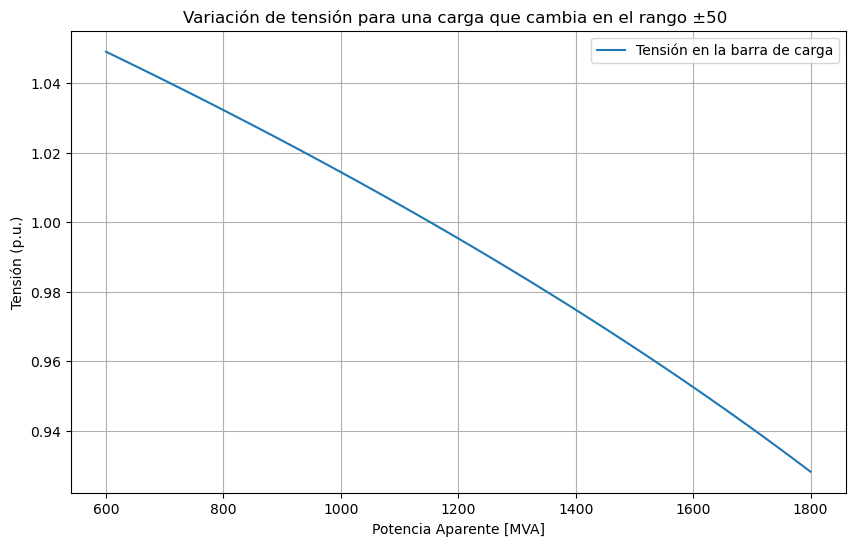

In [5]:
import pandapower as pp
import pandapower.plotting.plotly as plotly
import matplotlib.pyplot as plt
import numpy as np


net = pp.create_empty_network()
bus1 = pp.create_bus(net, name="Barra 1", vn_kv=500, type="b")
bus2 = pp.create_bus(net, name="Barra 2", vn_kv=500, type="b")

# mostrar tabla con barras
print(net.bus)

#Creando linea
linea_a= {"r_ohm_per_km": 0.02, "x_ohm_per_km": 0.115, "c_nf_per_km": 19.1, "max_i_ka": 1}
pp.create_std_type(net, name="linea_a", data=linea_a, element="line")
pp.available_std_types(net, element="line")

# Línea
line1 = pp.create_line(net, from_bus=bus1, to_bus=bus2, length_km=500, std_type="linea_a", name="Línea 1", parallel=2)

print(net.line)


# Añadir una fuente externa
pp.create_ext_grid(net, bus1, vm_pu=1, name="Grid Connection")


#------------Variando la carga------------------ 

# Crear una carga en la barra 2
p_mw_inicial = 1080
q_mvar_inicial = 523.03
pp.create_load(net, bus2, p_mw=p_mw_inicial, q_mvar=q_mvar_inicial, name="Carga")

# Variar la potencia activa y reactiva
p_mw_min = p_mw_inicial * 0.5
p_mw_max = p_mw_inicial * 1.5
q_mvar_min = q_mvar_inicial * 0.5
q_mvar_max = q_mvar_inicial * 1.5
p_mw_range = np.linspace(p_mw_min, p_mw_max, num=100)
q_mvar_range = np.linspace(q_mvar_min, q_mvar_max, num=100)

# Listas para almacenar
potencias_aparentes = []
voltages = []

for p_mw, q_mvar in zip(p_mw_range, q_mvar_range):
    net.load.loc[0, 'p_mw'] = p_mw
    net.load.loc[0, 'q_mvar'] = q_mvar
    pp.runpp(net, max_iteration=2000, tolerance_mva=1*10**(-10))
    # Guardar la tensión en el bus de la carga
    voltages.append(net.res_bus.vm_pu[bus2])
    s_mva = np.sqrt(p_mw**2 + q_mvar**2)
    potencias_aparentes.append(s_mva)

print("Tensión receptor=", voltages)
plt.figure(figsize=(10, 6))
plt.plot(potencias_aparentes, voltages, label='Tensión en la barra de carga')
plt.xlabel('Potencia Aparente [MVA]')
plt.ylabel('Tensión (p.u.)')
plt.title('Variación de tensión para una carga que cambia en el rango ±50 ')
plt.legend()
plt.grid(True)
plt.show()


#### Justificación teórica

Es razonable que, a mayor potencia consumida por la carga, mayor sea la caída de tensión, ya que aumenta la demanda de corriente en el sistema.

## 3.b) Compensación

In [ ]:
#Dado la matriz voltages referente a Voltaje receptor en pu previamente obtenida tenemos 
voltages=[1.0490783862373625, 1.0480882621559247, 1.047094687822527, 1.0460976373455344, 1.045097084488373, 1.0440930026631317, 1.0430853649240137, 1.042074143960626, 1.0410593120911094, 1.0400408412550985, 1.0390187030065106, 1.0379928685061557, 1.036963308514162, 1.0359299933822173, 1.034892893045607, 1.0338519770150612, 1.0328072143683875, 1.0317585737418935, 1.030706023321589, 1.0296495308341613, 1.0285890635377137, 1.027524588212267, 1.0264560711500073, 1.0253834781452782, 1.024306774484306, 1.0232259249346527, 1.0221408937343819, 1.0210516445809352, 1.0199581406197027, 1.0188603444322841, 1.0177582180244225, 1.016651722813606, 1.0155408196163351, 1.014425468634979, 1.0133056294443703, 1.012181260977901, 1.0110523215132858, 1.009918768657904, 1.0087805593337107, 1.0076376497617134, 1.0064899954459934, 1.0053375511572515, 1.004180270915867, 1.0030181079744502, 1.0018510147998694, 1.0006789430547298, 0.9995018435782916, 0.9983196663667991, 0.9971323605531994, 0.9959398743862329, 0.9947421552088644, 0.9935391494360352, 0.992330802531702, 0.9911170589851478, 0.9898978622865225, 0.9886731549015877, 0.9874428782456397, 0.986206972656565, 0.984965377367007, 0.9837180304755758, 0.9824648689171773, 0.9812058284321772, 0.9799408435346482, 0.9786698474794601, 0.977392772228235, 0.9761095484141096, 0.9748201053052542, 0.9735243707670909, 0.9722222712231589, 0.9709137316145606, 0.9695986753579318, 0.9682770243018655, 0.9669486986817204, 0.965613617072741, 0.9642716963414093, 0.9629228515949513, 0.9615669961289031, 0.9602040413726528, 0.9588338968328607, 0.9574564700346493, 0.9560716664604647, 0.9546793894864846, 0.9532795403164642, 0.9518720179128808, 0.950456718925247, 0.949033537615451, 0.9476023657799654, 0.9461630926687666, 0.9447156049007964, 0.9432597863757725, 0.9417955181821703, 0.9403226785011535, 0.9388411425062445, 0.9373507822584989, 0.9358514665969329, 0.9343430610239412, 0.9328254275854215, 0.9312984247453006, 0.9297619072541468, 0.928215726011516]
k=0
cant_med= len (voltages)
vs=1 
compensacion= []

while k <= cant_med:
    vr=voltages[k]
    if vr==vs
        compensacion[k]= 1
    if vr <= vs


        
        comensacion [k]= 
    if vr >= vs

    else 
        print("error")
    k=k+1
    



In [24]:
pp.runpp(net)
print("Flujo de carga inicial")
print(net.res_bus)

# Parámetros deseados
desired_voltage_pu = 1.0  # Voltaje deseado en pu

# Método iterativo para encontrar la capacitancia shunt
q_shunt = 0  # Potencia reactiva inicial del shunt
step = 1  # Paso de iteración

# Iterar para encontrar la q_mvar necesaria para el voltaje deseado
while True:
    # Añadir o actualizar el shunt
    if "shunt" in net and not net.shunt.empty:
        net.shunt.q_mvar.at[0] = q_shunt
    else:
        pp.create_shunt(net, bus=bus2, q_mvar=q_shunt, p_mw=0.0)

    # Ejecutar el flujo de carga
    pp.runpp(net)

    # Obtener el voltaje actual del bus 2
    voltage_pu = net.res_bus.vm_pu.at[bus2]
    print(f"Q_shunt: {q_shunt:.4f} MVAr, Voltage at bus 2: {voltage_pu:.4f} pu")

    # Verificar si el voltaje está dentro del rango deseado
    if np.abs(voltage_pu - desired_voltage_pu) < 0.001:
        break

    # Ajustar la q_mvar del shunt
    q_shunt += step * (desired_voltage_pu - voltage_pu)

print("Compensación shunt calculada")
print(f"Capacitancia shunt necesaria: {q_shunt:.4f} MVAr")
print("Flujo de carga después de añadir la compensación shunt")
print(net.res_bus)

# Graficar la red
pp.plotting.simple_plot(net)
plt.show()


Flujo de carga inicial
      vm_pu  va_degree         p_mw     q_mvar
0  1.000000   0.000000 -1681.364372  258.90103
1  0.928216 -11.404104  1620.000000  784.54500
Q_shunt: 0.0000 MVAr, Voltage at bus 2: 0.9282 pu
Q_shunt: 0.0718 MVAr, Voltage at bus 2: 0.9282 pu
Q_shunt: 0.1436 MVAr, Voltage at bus 2: 0.9282 pu
Q_shunt: 0.2154 MVAr, Voltage at bus 2: 0.9282 pu
Q_shunt: 0.2872 MVAr, Voltage at bus 2: 0.9282 pu
Q_shunt: 0.3590 MVAr, Voltage at bus 2: 0.9282 pu
Q_shunt: 0.4309 MVAr, Voltage at bus 2: 0.9282 pu
Q_shunt: 0.5027 MVAr, Voltage at bus 2: 0.9281 pu
Q_shunt: 0.5746 MVAr, Voltage at bus 2: 0.9281 pu
Q_shunt: 0.6464 MVAr, Voltage at bus 2: 0.9281 pu
Q_shunt: 0.7183 MVAr, Voltage at bus 2: 0.9281 pu
Q_shunt: 0.7902 MVAr, Voltage at bus 2: 0.9281 pu
Q_shunt: 0.8621 MVAr, Voltage at bus 2: 0.9281 pu
Q_shunt: 0.9340 MVAr, Voltage at bus 2: 0.9281 pu
Q_shunt: 1.0059 MVAr, Voltage at bus 2: 0.9281 pu
Q_shunt: 1.0778 MVAr, Voltage at bus 2: 0.9281 pu
Q_shunt: 1.1498 MVAr, Voltage at bus

KeyboardInterrupt: 

In [ ]:
print(voltages)

X= 0.003604[μs]

C= 11[μF]

In [23]:
from sympy import symbols, Eq, solve
from sympy import solve
import cmath
import sympy as sp
import math

x=sp.symbols('x')
#---------Párametros obtenidos previamente---------
A = 0.97741975+0.00392699999999999j
B = 9.849465+57.080301875j
C = -1.0280886000000084e-06+0.00077948849055j
D = 0.97741975+0.003926999999999999j
#-------------------Datos--------------------------
Sc= 1200*10**6
fp=0.9
Vs= (500*10**3)/np.sqrt(3)
#---------------Formulación----------------------
Vr=Vs
print("VS=",Vs)
Ir= (Sc)/Vr
angulo_grados = math.acos(fp)
Ir_fasor= cmath.rect(Ir,angulo_grados)
print("Ir_fasor=", Ir_fasor)

angulo_y= math.acos(0)
#x=float(x)
x_fasor= cmath.rect(x,angulo_y)

print("x=", x_fasor)
print(B*Ir_fasor)

eq= (((B*(x_fasor)+A)*Vr+B*Ir_fasor),Vs)
print(eq)
print(sp.solve(eq,x))
# Resolver la ecuación
soluciones = sp.solve(eq_2, x)
print(soluciones)

x + 6
VS= 288675.1345948129
Ir_fasor= (3741.229744348775+1811.9602644649797j)


TypeError: Cannot convert expression to float

## 3.c) Pérdidas de línea para rango de pot deman y rango de comp 

### Figura b
<div>
<img src="Figura b.png" width="500"/>
</div>


## 4.a) Identificar líneas saturadas o fuera de norma

### Gráfico Estado líneas

In [32]:
import pandapower as pp

net = pp.create_empty_network()
bus1 = pp.create_bus(net, name="Barra 1", vn_kv=110, type="b")
bus2 = pp.create_bus(net, name="Barra 2", vn_kv=220, type="b")
bus3 = pp.create_bus(net, name="Barra 2", vn_kv=220, type="b")
bus4 = pp.create_bus(net, name="Barra 2", vn_kv=220, type="b")
bus5 = pp.create_bus(net, name="Barra 2", vn_kv=220, type="b")
bus6 = pp.create_bus(net, name="Barra 2", vn_kv=220, type="b")
bus7 = pp.create_bus(net, name="Barra 2", vn_kv=220, type="b")


# Línea
line1 = pp.create_line(net, from_bus=bus2, to_bus=bus3, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", name="Línea 1")
line2 = pp.create_line(net, from_bus=bus3, to_bus=bus4, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", name="Línea 2")
line3 = pp.create_line(net, from_bus=bus4, to_bus=bus5, length_km=20, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", name="Línea 3")
line4 = pp.create_line(net, from_bus=bus5, to_bus=bus6, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", name="Línea 4")
line5 = pp.create_line(net, from_bus=bus6, to_bus=bus7, length_km=30, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", name="Línea 5")
line6 = pp.create_line(net, from_bus=bus7, to_bus=bus2, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", name="Línea 6")

# Añadir una fuente externa
pp.create_ext_grid(net, bus1, vm_pu=1, name="Grid Connection")

#trafo
trafo1 = pp.create_transformer(net, bus1, bus2, name="110kV/20kV transformer", std_type="100 MVA 220/110 kV")


#cargas 
p_mw = 150
q_mvar = 100
pp.create_load(net, bus3, p_mw=p_mw*0.2, q_mvar=q_mvar*0.2, name="Carga_3")
pp.create_load(net, bus4, p_mw=p_mw*0.35, q_mvar=q_mvar*0.35, name="Carga_4")
pp.create_load(net, bus5, p_mw=p_mw*0.15, q_mvar=q_mvar*0.15, name="Carga_5")
pp.create_load(net, bus6, p_mw=p_mw*0.6, q_mvar=q_mvar*0.6, name="Carga_6")
pp.create_load(net, bus7, p_mw=p_mw*0.1, q_mvar=q_mvar*0.1, name="Carga_7")


pp.runpp(net, max_iteration=2000, tolerance_mva=1*10**(-10))
# Guardar la tensión en el bus de la carga
voltages.append(net.res_bus.vm_pu[bus2])




LoadflowNotConverged: Power Flow nr did not converge after 2000 iterations!

### Método para resolver problema 

## 4.b) Identificar si las Tensiones de las barras estan fuera de norma según ambos escenarios 

### Estado Normal

### Estado Alerta

## 4.c) 

## 4.d)

## 4.e)

## 4.f)

## 4.g)